# Exhaustive Framework for Risk Management and Anomaly Detection in Highly Imbalanced Datasets

As technology continues to advance, the prevalence of cyber security risks has become more pronounced. The digital landscape provides ample opportunities for malicious actors to exploit vulnerabilities in various systems by ways of phishing attacks, ransomware, social engineering tactics, and detection evading automated programs and scripts. Machine learning provides an invaluable role in risk management and can fortify threat detection mechanisms to identify and prevent fradulent activities, and maintaining the integrity of systems and transactions.

However, finding the right balance between robust anomaly detection and user convenience is a chllenging task for organizations, and machine learning models tend to perform well on the majority class, leading to potential oversight of minority class instances such as rare anomaly cases. In this tutorial, we will explore the predictive strengths of several machine learning techniques such as Random Forest, AdaBoost, CatBoost, XGBoost, and LightGBM, on both the majority and minority class, and compare techniques to address the class imbalance issue using oversampling (E.g., SMOTE, ADASYN) and stratified sampling (E.g., Stratified K-Fold Cross Validation) techniques.

### Context

The dataset can be found in Kaggle, and contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly imbalanced, with the positive class (frauds) accounting for 0.172% of all transactions.

The dataset contains only numerical inputs:
- __Time__ contains the seconds elapsed between each transaction and the first transaction in the dataset
- __Amount__ containing the transaction Amount
- __Class__ is the response variable and it takes value 1 in case of fraud and 0 otherwise
- __V1, V2, ... , V28__ are the principal components of the PCA transformation of the other original features.


### Data Preprocessing

In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
import os
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import ADASYN
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

%matplotlib inline 
init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 100)

In [2]:
data_df = pd.read_csv('creditcard.csv')

print(data_df.shape)
# data has rows: 284807  columns: 31

data_df.head()

data_df.describe()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Exploratory Data Analysis

In [3]:
# check missing data

total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Time,V16,Amount,V28,V27,V26,V25,V24,V23,V22,V21,V20,V19,V18,V17,V15,V1,V14,V13,V12,V11,V10,V9,V8,V7,V6,V5,V4,V3,V2,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The dataset does not contain any missing data.

In [4]:
# check for data imbalance

temp = data_df["Class"].value_counts()
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'Class', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

Only 492 (or 0.172%) of transactions are fraudulent. The data is highly imbalanced with respect to the target variable Class.

In [5]:
# time density plot for transactions

class_0 = data_df.loc[data_df['Class'] == 0]["Time"]
class_1 = data_df.loc[data_df['Class'] == 1]["Time"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

Fraudulent transactions are more evenly distributed compared to valid transactions.

In [6]:
# statistical summaries of fraud and non-fraud transactions by hour

data_df['Hour'] = data_df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = data_df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


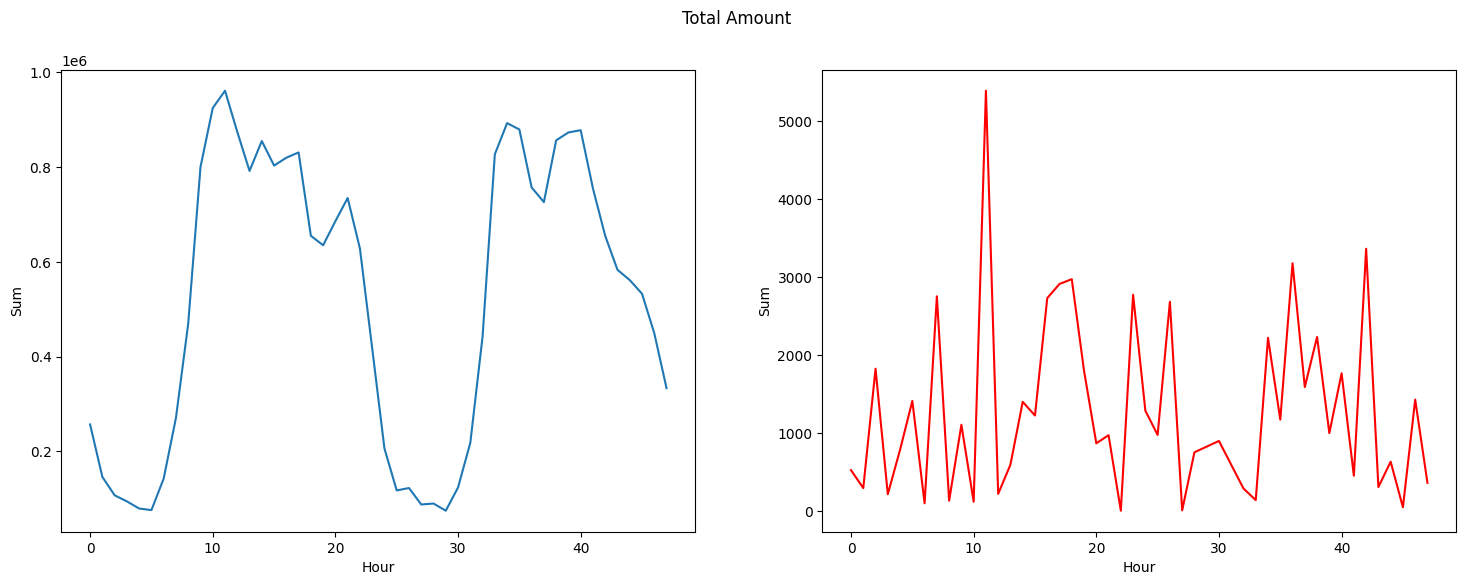

In [7]:
# total amount by class, non-fraud is blue and fraud is red

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show();

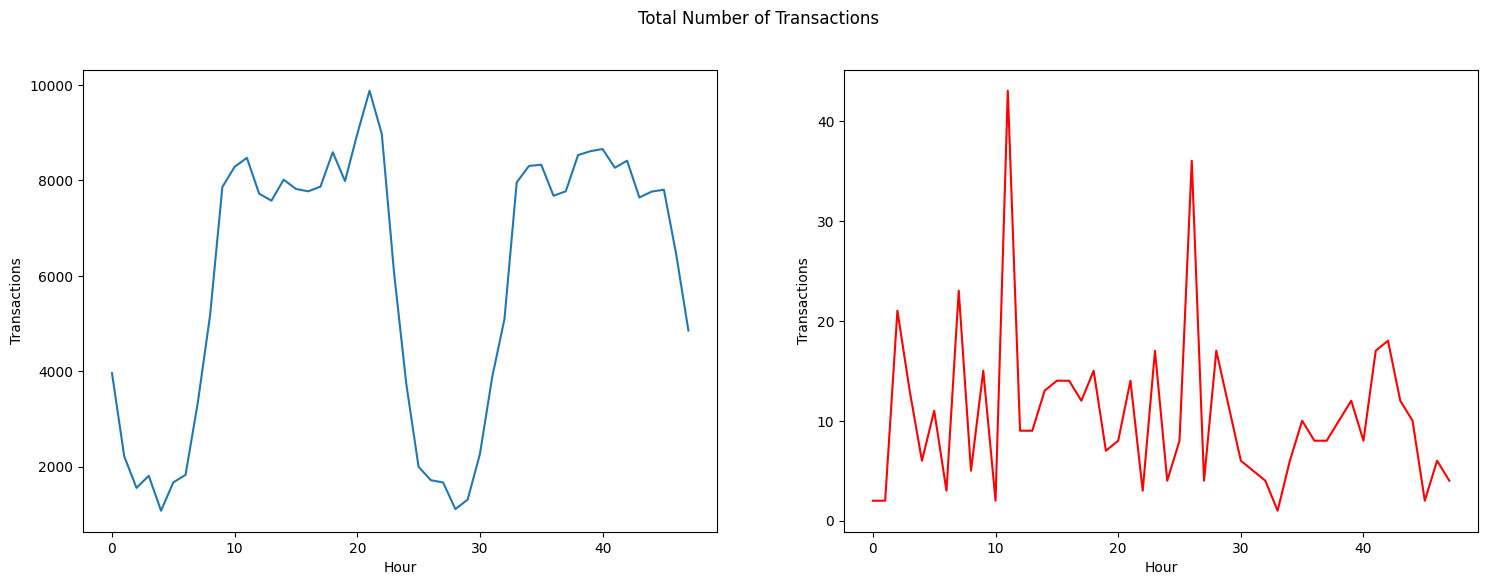

In [8]:
# total number of transactions by class, non-fraud is blue and fraud is red

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Number of Transactions")
plt.show();

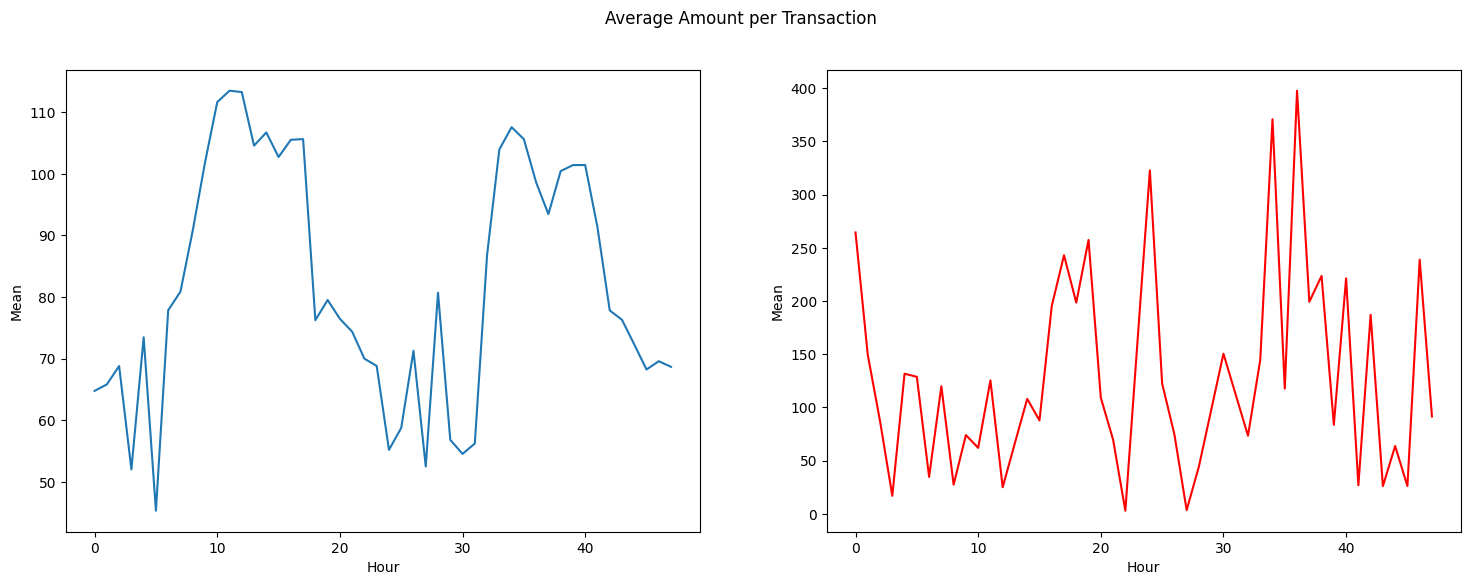

In [9]:
# average amount per transaction by class, non-fraud is blue and fraud is red

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Average Amount per Transaction")
plt.show();

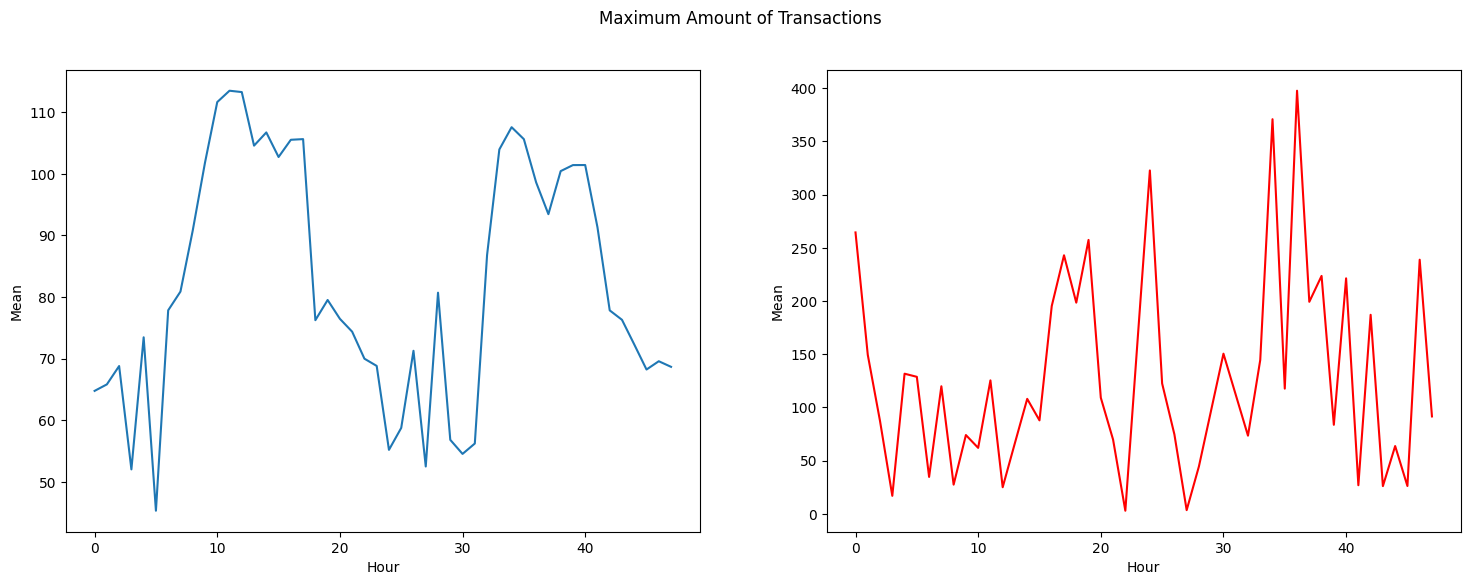

In [10]:
# maximum amount of transaction by class, non-fraud is blue and fraud is red

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show();

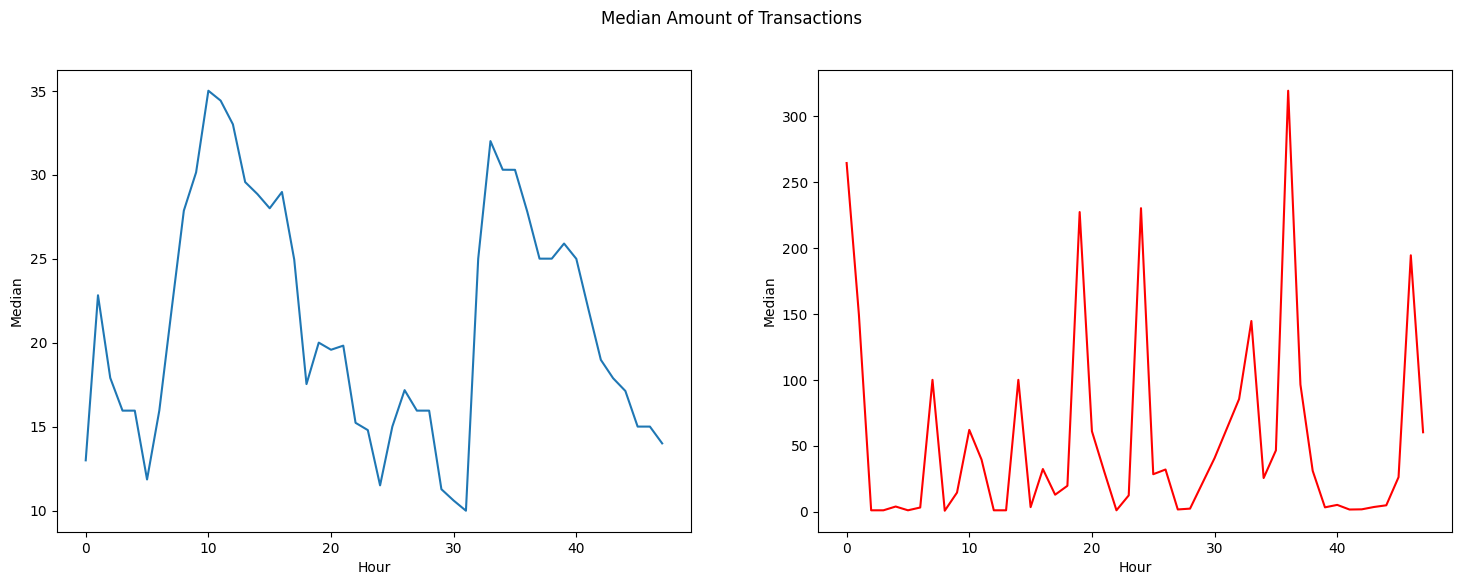

In [11]:
# median amount of transaction by class, non-fraud is blue and fraud is red

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=df.loc[df.Class==1], color="red")
plt.suptitle("Median Amount of Transactions")
plt.show();

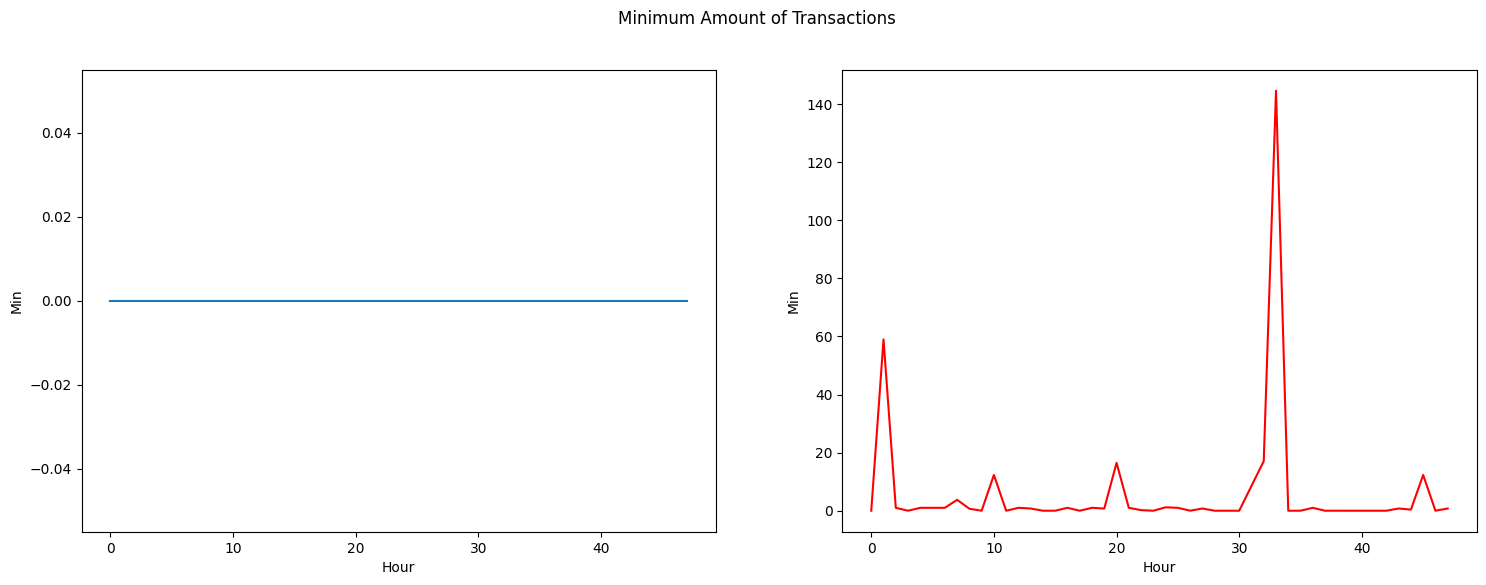

In [12]:
# minimum amount of transaction by class, non-fraud is blue and fraud is red

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red")
plt.suptitle("Minimum Amount of Transactions")
plt.show();

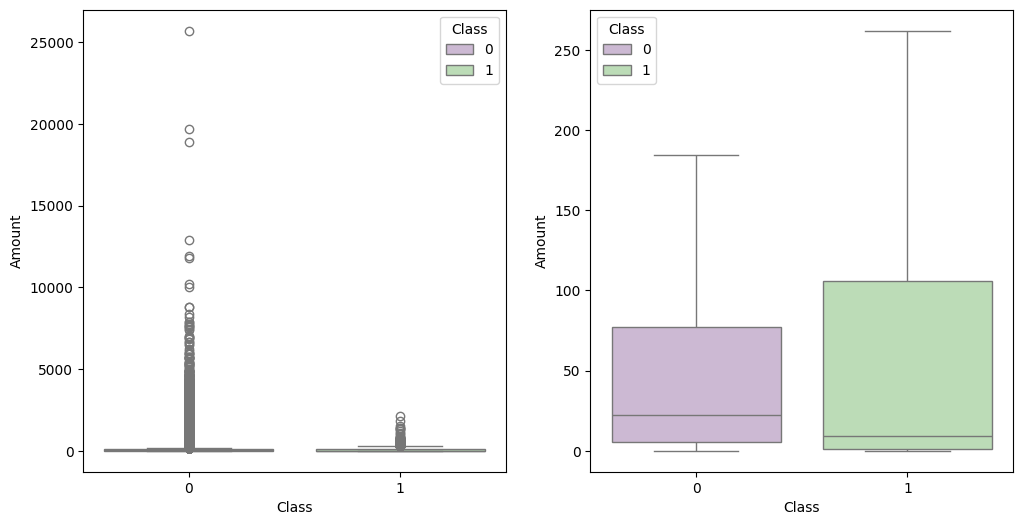

In [13]:
# summary statistics of both classes, with and without outliers

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=False)
plt.show();

In [14]:
tmp = data_df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [15]:
class_1.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Using median as the average, real transactions have a larger average value and Q1, smaller Q3 and larger outliers. Fraudulent transactions have a smaller average and Q1, larger Q3 and smaller outliers.

In [16]:
# plot of fradulent transactions, amount against time in seconds

fraud = data_df.loc[data_df['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Time [s]', showticklabels=True), 
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

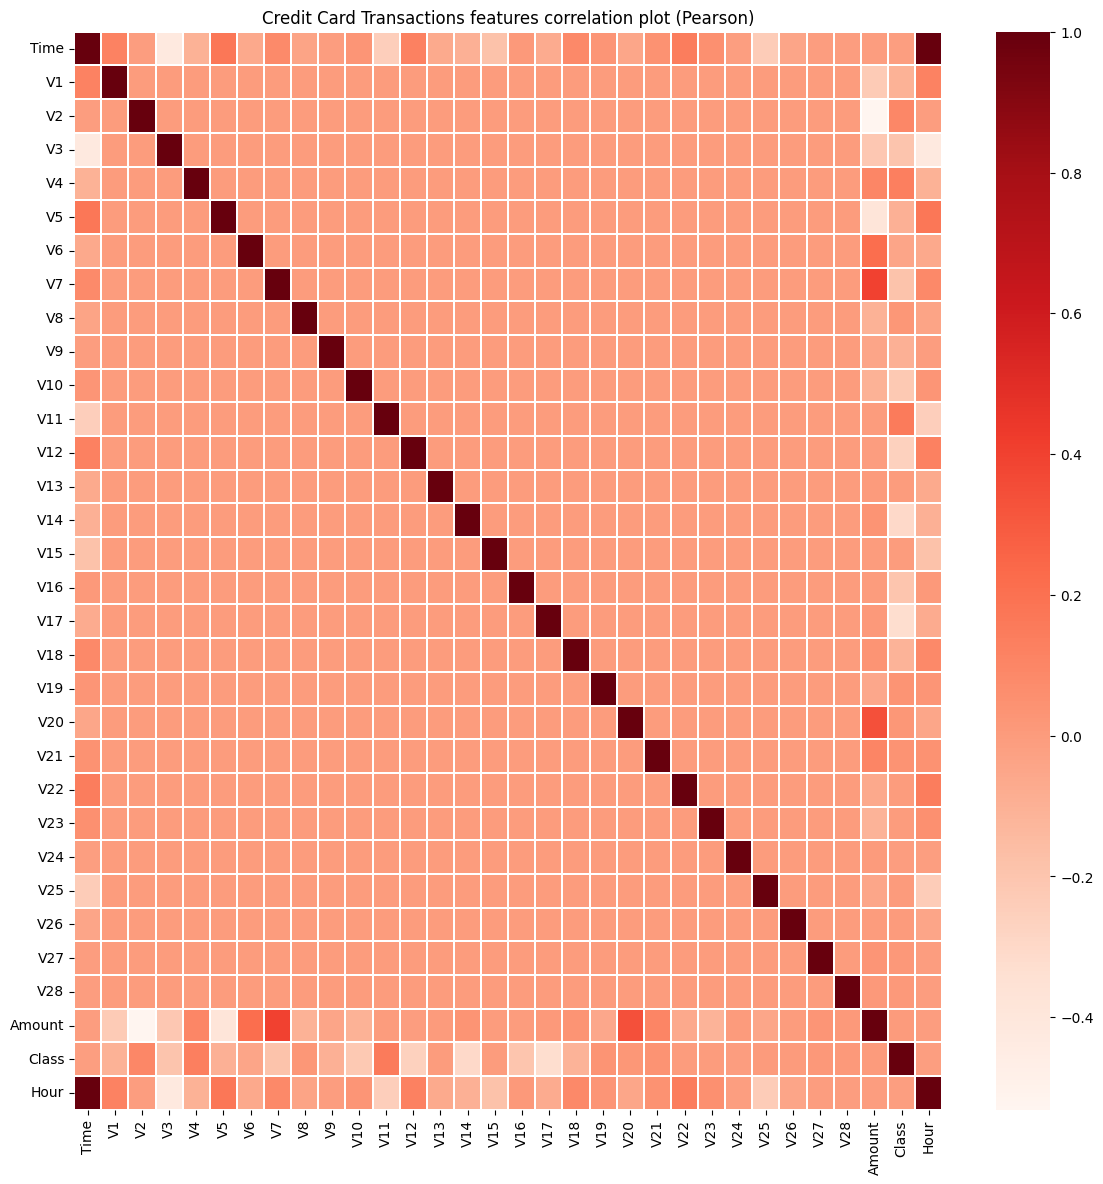

In [17]:
# features correlation

plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

Because V1-V28 is obtained from PCA, we notice that there is no notable correlation between them. However, there are certain correlations between some of these features and Time (inverse correlation with V3) and Amount (direct correlation with V7 and V20, inverse correlation with V2 and V5).

c:\Users\wl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning:

The figure layout has changed to tight

c:\Users\wl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning:

The figure layout has changed to tight



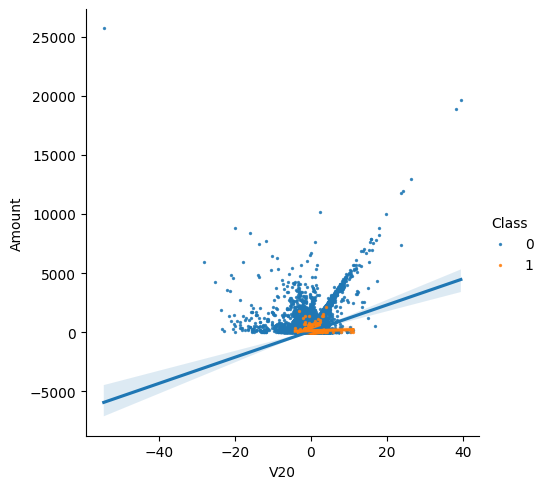

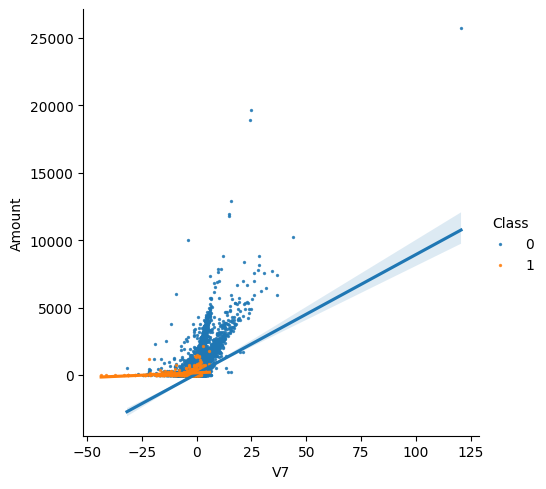

In [18]:
# regression line for Amount against V20 and V7

s = sns.lmplot(x='V20', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

We can confirm that the two couples of features are correlated (the regression lines for Class = 0 have a positive slope, whilst the regression line for Class = 1 have a smaller positive slope).

c:\Users\wl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning:

The figure layout has changed to tight

c:\Users\wl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning:

The figure layout has changed to tight



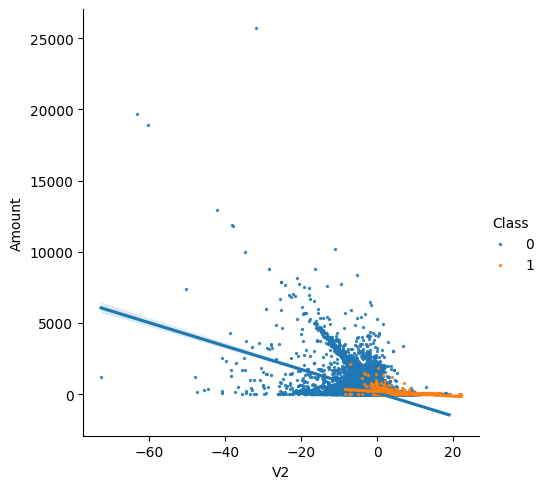

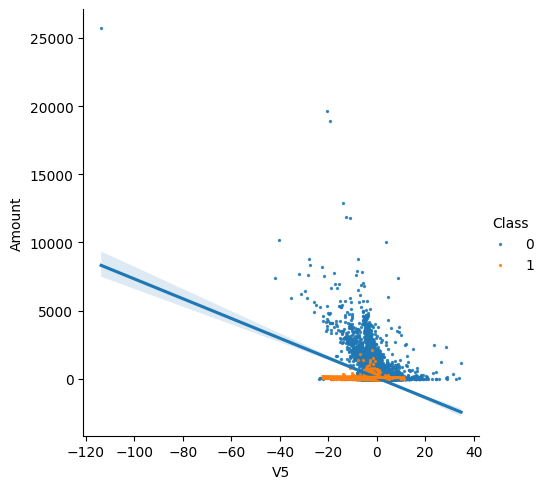

In [19]:
# regression line for Amount against V2 and V5

s = sns.lmplot(x='V2', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

We can confirm that the two couples of features are inverse correlated (the regression lines for Class = 0 have a negative slope while the regression lines for Class = 1 have a very small negative slope).

<Figure size 640x480 with 0 Axes>

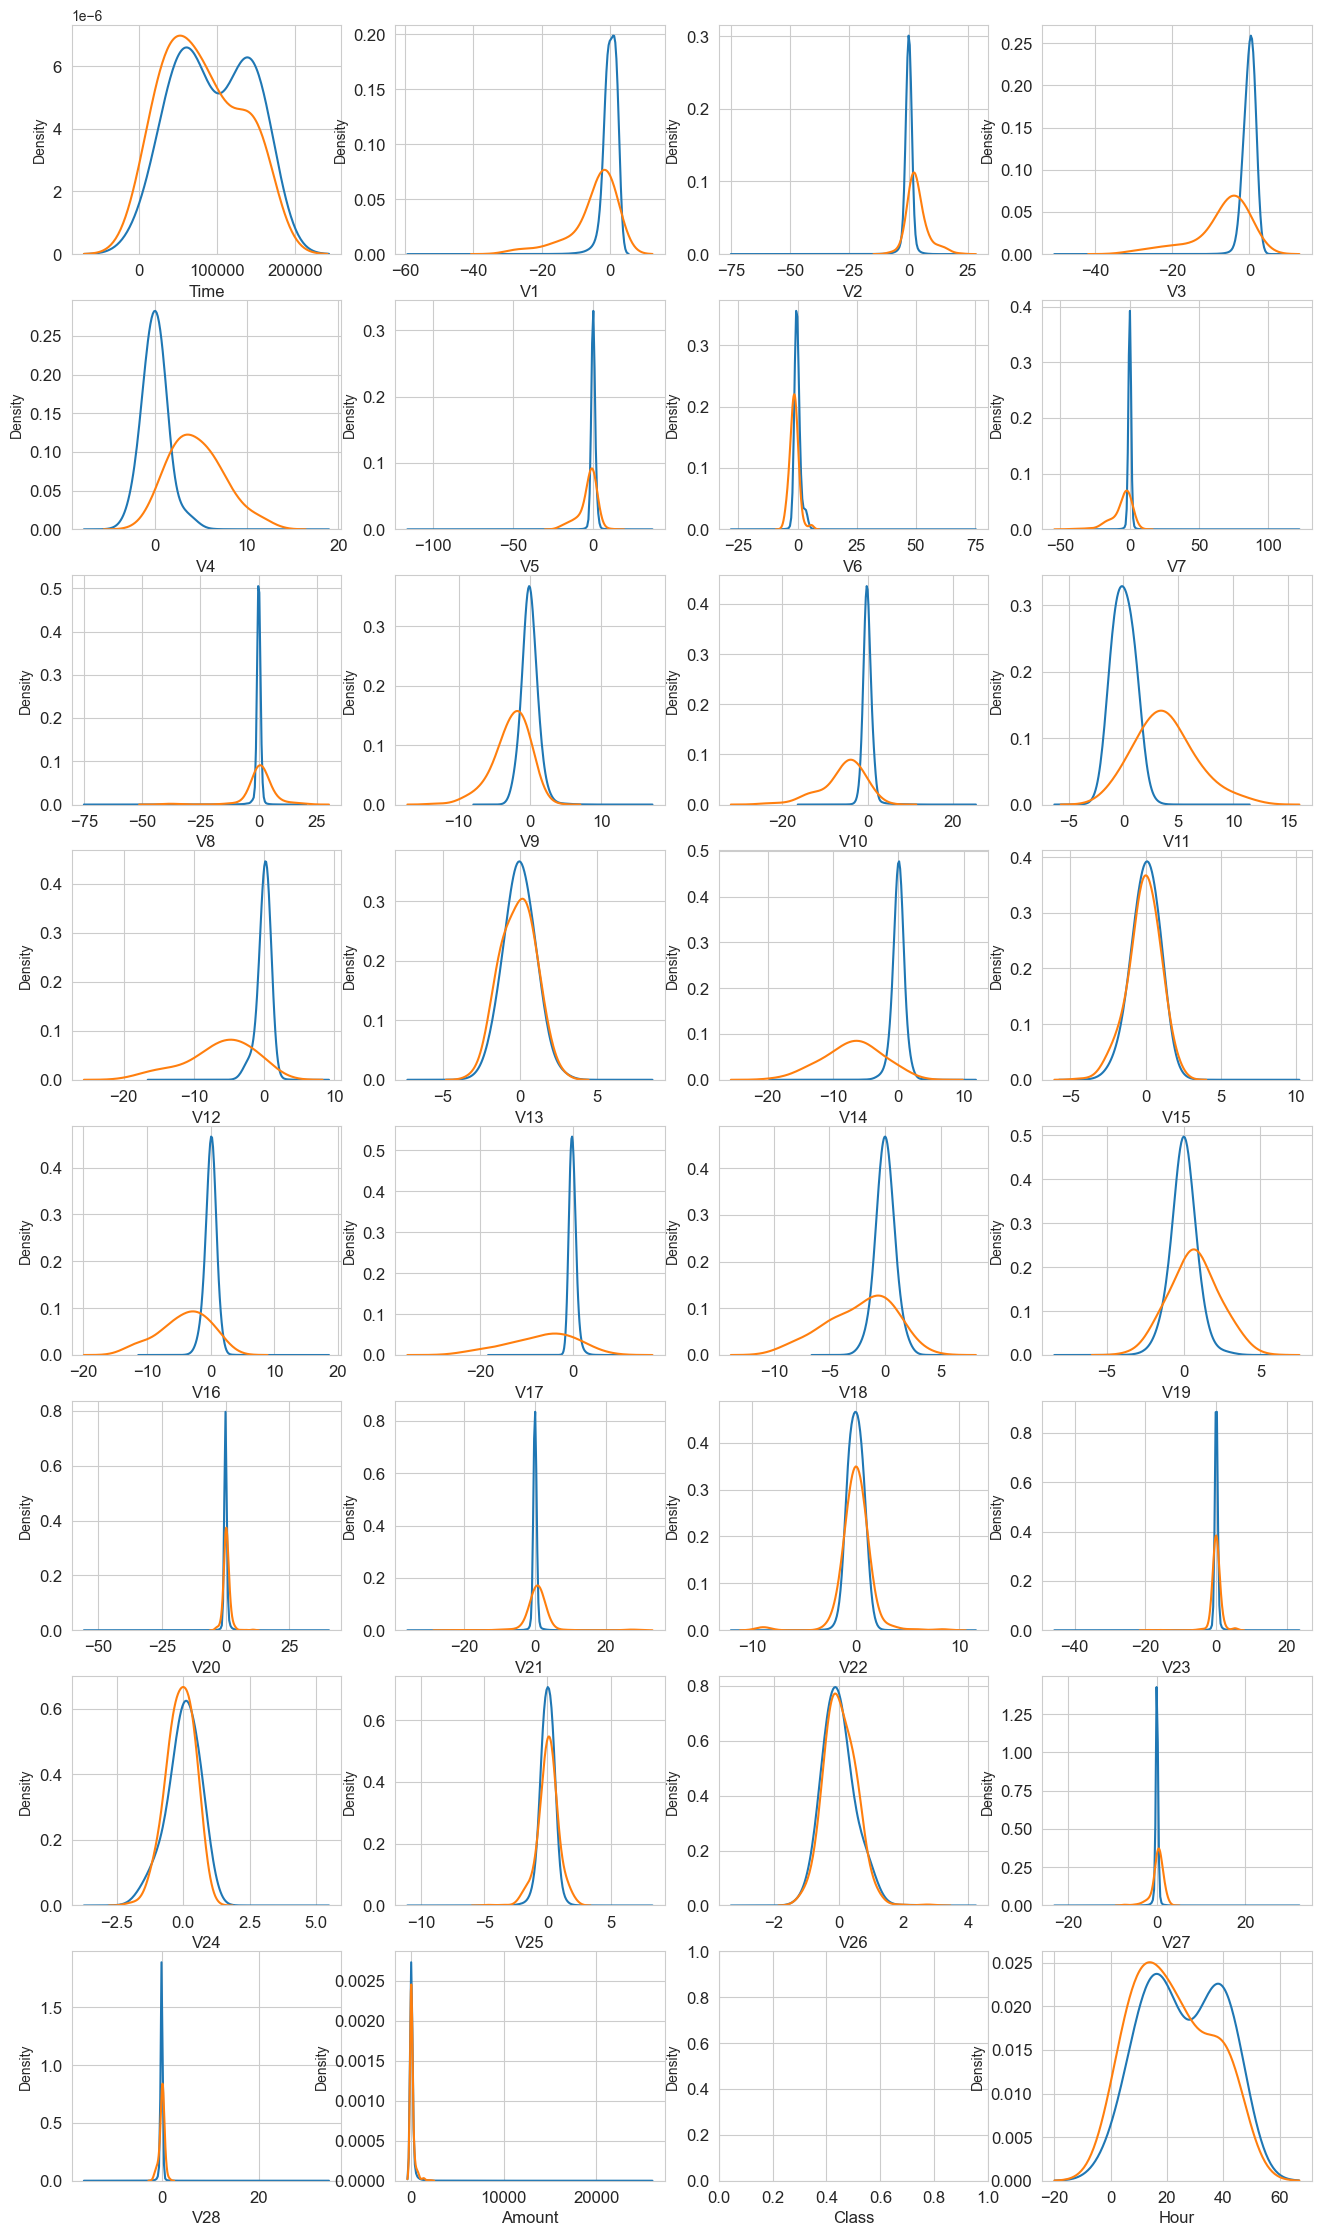

In [20]:
# Features density plot

var = data_df.columns.values

i = 0
t0 = data_df.loc[data_df['Class'] == 0]
t1 = data_df.loc[data_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw_method=0.5,label="Class = 0", warn_singular=False)
    sns.kdeplot(t1[feature], bw_method=0.5,label="Class = 1", warn_singular=False)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

V4 and V11 have clearly separated distributions for Class values 0 and 1. V12, V14, V18 are partially separated. V1, V2, V3, V10 have a quite distinct profile, whilst V25, V26, V28 have similar profiles for the two values of Class.

In general, with just few exceptions (Time and Amount), the features distribution for legitimate transactions is centered around 0, sometime with a long queue at one of the extremities, while the fraudulent transactions (values of Class = 1) have a skewed (asymmetric) distribution.

### Feature Engineering

In [21]:
# stratified Train/Validation/Test split

target = 'Class'

VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split
RANDOM_STATE = 333

X = data_df.drop([target, 'Hour'],axis = 1)
Y = data_df[target]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, stratify=Y, random_state=RANDOM_STATE, shuffle=True)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=VALID_SIZE, stratify=Y_train, random_state=RANDOM_STATE, shuffle=True)


We will now proceed with scaling. Max-min Normalization features will have a small Standard deviation compared to Standardization. Normalization will scale most of the data to a small interval, which means all features will have a small scale but do not handle outliers well. Whereas, Standardization is robust to outliers. They transform the probability distribution for an input variable to standard Gaussian Standardization and can become skewed or biased if the input variable contains outlier values.

To overcome this, the median and Interquartile range can be used when standardizing numerical input variables which technique is referred to as robust scaling. Robust scaling uses percentile to scale numerical input variables that contain outliers by scaling numerical input variables using the median and interquartile range. It calculated the median, 25th, and 75th percentiles. The value of each variable is then subtracted with median and divided by Interquartile range (IQR). Value = (value- median) / (p75 — p25)

This results in variable having mean to 0, median and standard deviation to 1.

In [22]:
# robust scaling

rob_scaler_amount = RobustScaler()
rob_scaler_time = RobustScaler()
rob_scaler_amount.fit(X_train['Amount'].values.reshape(-1,1))
rob_scaler_time.fit(X_train['Time'].values.reshape(-1,1))
X_train['Time'] = rob_scaler_amount.transform(X_train['Amount'].values.reshape(-1,1))
X_train['Amount'] = rob_scaler_time.transform(X_train['Time'].values.reshape(-1,1))
X_valid['Time'] = rob_scaler_amount.transform(X_valid['Amount'].values.reshape(-1,1))
X_valid['Amount'] = rob_scaler_time.transform(X_valid['Time'].values.reshape(-1,1))
X_test['Time'] = rob_scaler_amount.transform(X_test['Amount'].values.reshape(-1,1))
X_test['Amount'] = rob_scaler_time.transform(X_test['Time'].values.reshape(-1,1))
X_train.head()
X_valid.head()
X_test.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
220284,1.729805,1.612079,-1.094866,-0.885544,0.067156,0.257474,2.038159,-0.868182,0.593030,0.977669,-0.031065,0.753302,1.181532,0.488862,-0.076348,0.487433,-0.138896,-0.195437,-0.546918,-0.848834,0.076391,0.384747,1.082406,0.025439,-0.862288,-0.404911,0.693205,-0.002917,-0.044070,-0.994961
184809,0.950395,-0.755636,0.624208,0.219524,0.860833,1.122233,-0.492817,1.901163,-0.939014,0.108492,1.318790,0.722679,-0.593610,-2.165657,0.252763,-0.651627,-1.196825,-0.284852,0.182142,1.074624,-0.135718,-0.027988,0.711444,-0.481262,0.010741,-0.203651,-0.521172,-0.541903,-0.323330,-0.994970
41716,0.325620,0.999431,-0.345812,2.004894,2.991637,-1.209099,1.261607,-1.206404,0.482116,1.211884,0.225812,-2.130470,0.237993,-0.170618,-1.272877,-1.846557,0.268887,-0.084305,0.104976,-0.370298,-0.088962,0.053318,0.538555,-0.210855,-0.061398,0.516914,0.277666,0.084727,0.041530,-0.994978
98930,0.041569,-1.256138,-0.275826,1.345067,-1.291546,-0.670270,-1.735003,-0.283084,0.276912,-1.513398,-0.203997,-0.471504,-0.124961,0.042298,0.358470,0.197434,-1.082831,0.064936,0.884384,-1.539923,-0.397853,-0.199660,-0.590355,0.123883,0.932061,-0.496332,0.718777,-0.078604,-0.049149,-0.994981
215850,3.044063,-0.934221,0.884029,-0.229657,4.505453,0.931277,1.552456,0.074438,-2.803824,-1.762919,1.427396,-1.993873,-1.258808,-1.024011,0.669878,0.238222,-0.042022,0.102783,0.065821,1.502694,0.842683,-1.555775,-0.005441,0.213812,0.035725,-1.174592,0.032404,0.515076,0.031185,-0.994946


Since our train data is highly imbalance with way fewer fraudulent case (less than 0.2%) compared to non-fraudulent case, we can risk achieving high accuracy by consistently predicting the majority class but not the minority class. To tackle this, we can apply oversampling technique, specifically choosing ADASYN instead of other techniques like SMOTE to balance the highly imbalance training data. The main difference between them is that ADASYN generates synthetic samples adaptively based on the density distribution of minority class samples, while SMOTE generates synthetic samples by interpolating between minority class samples. For cases where data is highly imbalance, ADASYN is often considered more suitable as it focuses on generating synthetic samples in regions of the feature space where the class imbalance is most pronounced, but SMOTE treats all minority class instances equally in a uniform approach.

In [23]:
# oversampling train data with ADASYN

X_train, Y_train = ADASYN(random_state=RANDOM_STATE).fit_resample(X_train, Y_train)
Y_train.value_counts()

Class
0    181961
1    181954
Name: count, dtype: int64

### Modelling

#### Random Forest Classifier

In [24]:
# fitting the RFC model

RFC_METRIC = 'gini'
NUM_ESTIMATORS = 100
NO_JOBS = -1

clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

clf.fit(X_train, Y_train.values)

preds = clf.predict(X_valid)

C:\Users\wl\AppData\Local\Temp\ipykernel_12272\4268738381.py:8: UserWarning:

FixedFormatter should only be used together with FixedLocator



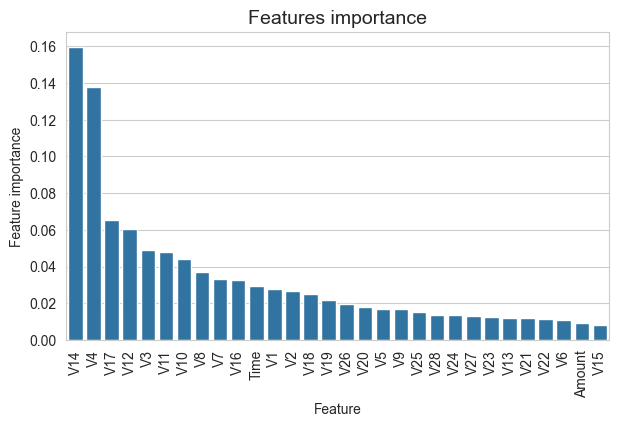

In [25]:
# feature importance

tmp = pd.DataFrame({'Feature': X_train.columns.to_numpy(), 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

The most important features are V14, V4, V17, V12.

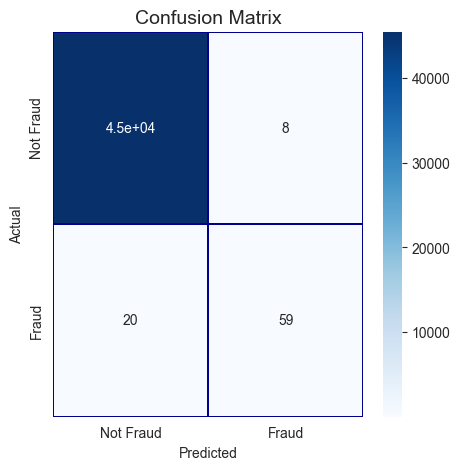

In [26]:
# confusion matrix

cm = pd.crosstab(Y_valid.values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [27]:
# AUC-ROC

roc_auc_score(Y_valid.values, preds)

0.8733297901054898

The ROC-AUC score obtained with RandomForestClassifier is 0.87.

#### AdaBoost Classifier

In [28]:
# fitting the AdaBoost model

clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                         n_estimators=NUM_ESTIMATORS)

clf.fit(X_train, Y_train.values)

preds = clf.predict(X_valid)

C:\Users\wl\AppData\Local\Temp\ipykernel_12272\1309414352.py:8: UserWarning:

FixedFormatter should only be used together with FixedLocator



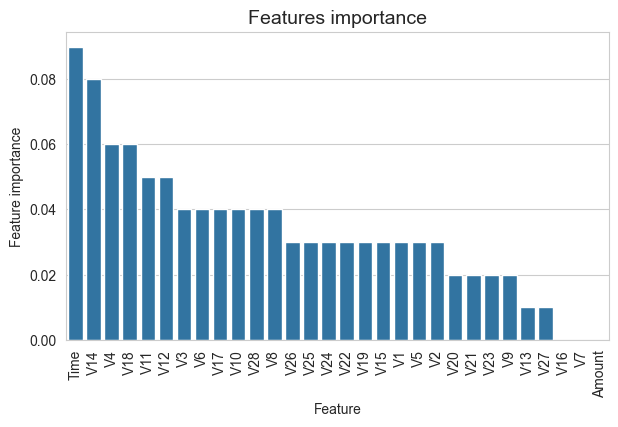

In [29]:
# feature importance

tmp = pd.DataFrame({'Feature': X_train.columns.to_numpy(), 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

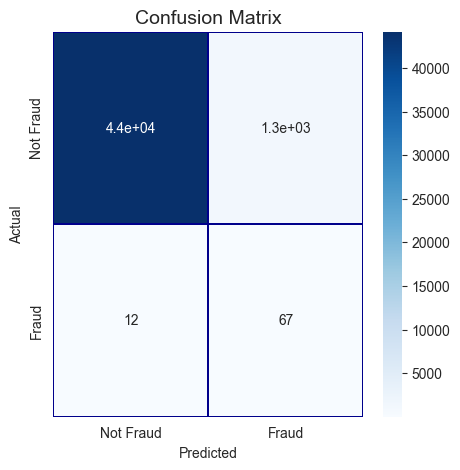

In [30]:
# confusion matrix

cm = pd.crosstab(Y_valid.values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [31]:
# AUC-ROC

roc_auc_score(Y_valid.values, preds)

0.9093331125772531

The ROC-AUC score obtained with AdaBoostClassifier is 0.91.

#### CatBoost Classifier

In [32]:
# CatBoostClassifier

VERBOSE_EVAL = 50

clf = CatBoostClassifier(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='AUC',
                         random_seed = RANDOM_STATE,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = VERBOSE_EVAL,
                         od_wait=100)

clf.fit(X_train, Y_train.values, eval_set=[(X_train, Y_train), (X_valid, Y_valid)])

preds = clf.predict(X_test)

0:	test: 0.9906886	test1: 0.9620136	best: 0.9620136 (0)	total: 742ms	remaining: 6m 10s
50:	test: 0.9997002	test1: 0.9740897	best: 0.9753887 (15)	total: 24s	remaining: 3m 31s
100:	test: 0.9998749	test1: 0.9792320	best: 0.9794816 (88)	total: 47.7s	remaining: 3m 8s
150:	test: 0.9999617	test1: 0.9806228	best: 0.9806512 (139)	total: 1m 9s	remaining: 2m 40s
200:	test: 0.9999906	test1: 0.9805026	best: 0.9811142 (164)	total: 1m 30s	remaining: 2m 14s
250:	test: 0.9999955	test1: 0.9796277	best: 0.9811142 (164)	total: 1m 51s	remaining: 1m 50s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9811142246
bestIteration = 164

Shrink model to first 165 iterations.


C:\Users\wl\AppData\Local\Temp\ipykernel_12272\1309414352.py:8: UserWarning:

FixedFormatter should only be used together with FixedLocator



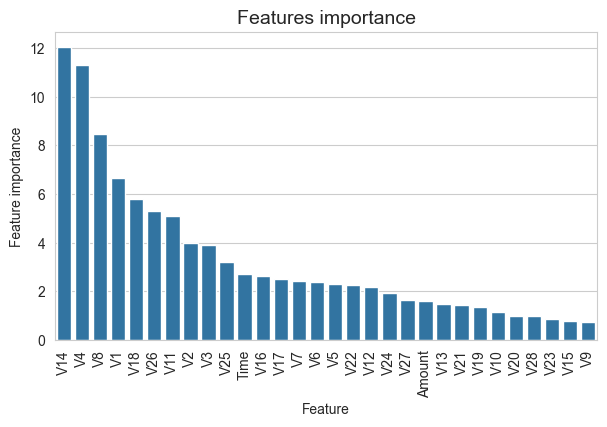

In [33]:
# feature importance

tmp = pd.DataFrame({'Feature': X_train.columns.to_numpy(), 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

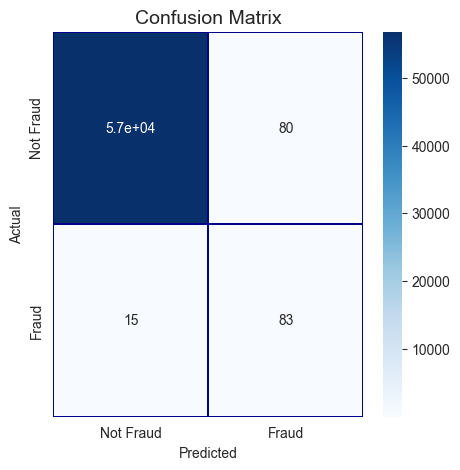

In [34]:
# confusion matrix
cm = pd.crosstab(Y_test.values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [35]:
# AUC-ROC

roc_auc_score(Y_test.values, preds)

0.9227659550032732

The ROC-AUC score obtained with CatBoostClassifier is 0.92.

#### XGBoost

In [36]:
# prepare the train and valid datasets
dtrain = xgb.DMatrix(X_train, Y_train.values)
dvalid = xgb.DMatrix(X_valid, Y_valid.values)
dtest = xgb.DMatrix(X_test, Y_test.values)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# set parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.01
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [37]:
# training the model

MAX_ROUNDS = 1000
EARLY_STOP = 50

model = xgb.train(params, 
                  dtrain, 
                  MAX_ROUNDS, 
                  watchlist, 
                  early_stopping_rounds=EARLY_STOP, 
                  maximize=True, 
                  verbose_eval=VERBOSE_EVAL)

c:\Users\wl\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning:

Pass `evals` as keyword args.

c:\Users\wl\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[19:20:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.




[0]	train-auc:0.87998	valid-auc:0.92656
[50]	train-auc:0.94238	valid-auc:0.97312
[85]	train-auc:0.94904	valid-auc:0.97334


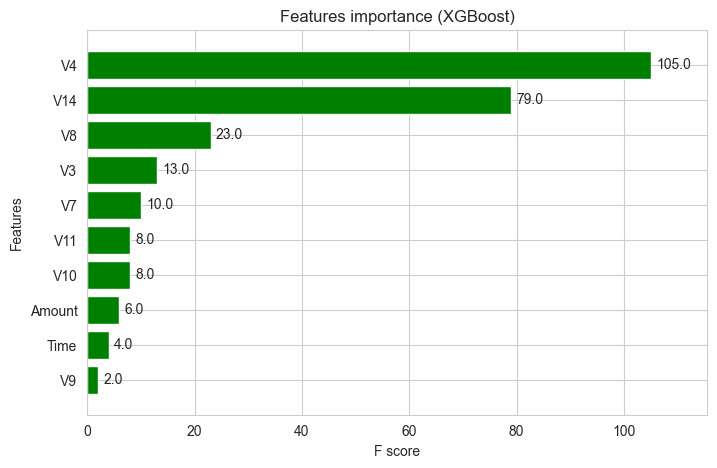

In [38]:
# feature importance

fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

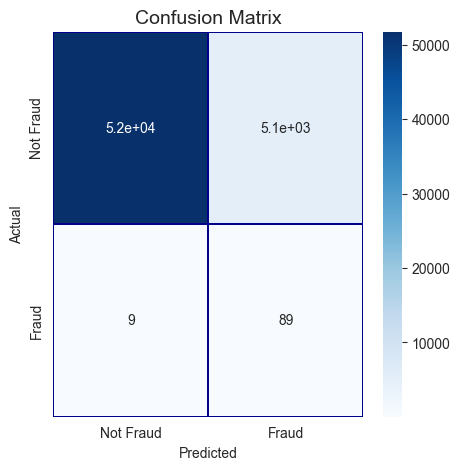

In [39]:
# confusion matrix
preds = model.predict(dtest)
preds = [round(value) for value in preds]

cm = pd.crosstab(Y_test.values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [40]:
# AUC-ROC

roc_auc_score(Y_test.values, preds)

0.9092905521803545

The AUC score for the prediction of fresh data (test set) for XGBoost is 0.91. Although the score is lower than CatBoost, the recall (accuracy on actual minority class) is higher.

#### LightGBM

In [41]:
# training the model

lgbm = LGBMClassifier(boosting_type= 'gbdt',
                      objective= 'binary',
                      metric='auc',
                      learning_rate= 0.01,
                      num_leaves= 7,  
                      max_depth= 4,  
                      min_child_samples= 100, 
                      max_bin= 100,  
                      subsample= 0.9, 
                      subsample_freq= 1, 
                      colsample_bytree= 0.7,  
                      min_child_weight= 0,  
                      min_split_gain= 0,  
                      n_jobs=os.cpu_count(),
                      verbose= 1,)

In [42]:
# fitting the model

lgbm.fit(X_train, Y_train.values, eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
        eval_metric='auc')

preds = lgbm.predict(X_test)

[LightGBM] [Info] Number of positive: 181954, number of negative: 181961
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3000
[LightGBM] [Info] Number of data points in the train set: 363915, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499990 -> initscore=-0.000038
[LightGBM] [Info] Start training from score -0.000038


C:\Users\wl\AppData\Local\Temp\ipykernel_12272\1049630776.py:8: UserWarning:

FixedFormatter should only be used together with FixedLocator



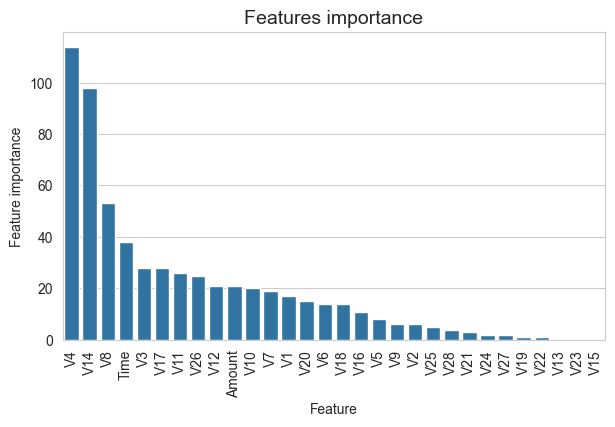

In [43]:
# feature importance

tmp = pd.DataFrame({'Feature': X_train.columns.to_numpy(), 'Feature importance': lgbm.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

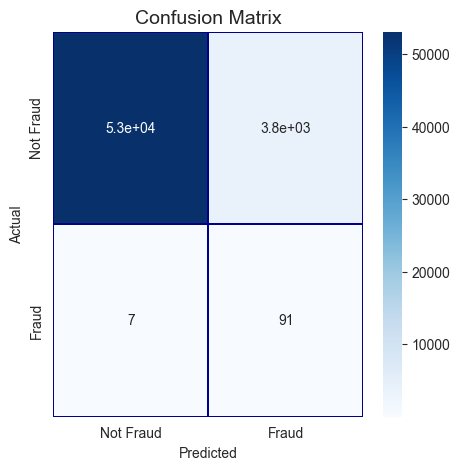

In [44]:
# confusion matrix

cm = pd.crosstab(Y_test.values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [45]:
# AUC-ROC

roc_auc_score(Y_test.values, preds)

0.931154031674572

The AUC-ROC score obtained with LightGBM is 0.93.

We observed that amongst all the models, LightGBM produces the best results with the highest accuracy. The recall is also the highest out of all the models.

To further improve our LightGBM model, we will proceed with hyperparameter tuning with Bayesian optimization and use stratified K-Fold cross validation technique for our training and validation sets.

#### Bayesian optimization, stratified K-Fold cross validation

In [46]:
# set initial parameters

X = data_df.drop([target, 'Hour'],axis = 1)
Y = data_df[target]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, stratify=Y, random_state=RANDOM_STATE, shuffle=True)

lgbm = LGBMClassifier(boosting_type='dart',
                      objective='binary',
                      metric='auc',
                      n_jobs=os.cpu_count(), 
                      verbose=-1,
                      random_state=RANDOM_STATE,
                      min_split_gain= 0, # or can regularize next step by searching L1/L2 
                      )

In [47]:
# specifying search space

search_spaces = {
    'learning_rate': Real(0.001, 0.01, 'log-uniform'),   
    'n_estimators' : Integer(50, 200),
    'num_leaves': Integer(10, 100),                    
    'max_depth': Integer(15, 100),                       
    'subsample': Real(0.1, 1.0, 'uniform'),           
    'subsample_freq': Integer(0, 10),                   
    'min_child_samples': Integer(10, 200),  
    #'reg_lambda': Real(1e-9, 100.0, 'log-uniform'),      # L2 regularization
    #'reg_alpha': Real(1e-9, 100.0, 'log-uniform'),       # L1 regularization
    }

In [48]:
# setting up the optimizer

opt = BayesSearchCV(estimator=lgbm,                                    
                    search_spaces=search_spaces,                                              
                    cv=5, # stratified K-Fold automatically used here (refer to documentation)
                    n_iter=30,                                   
                    n_points=3,                                       
                    n_jobs=-1,                                       
                    return_train_score=False,                         
                    refit=False,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},       
                    random_state=RANDOM_STATE)

In [49]:
# running the optimizer

np.int = np.int64 # skopt uses np.int which was deprecated, so we change it to np.int64 manually
opt.fit(X_train, Y_train)

BayesSearchCV(cv=5,
              estimator=LGBMClassifier(boosting_type='dart', metric='auc',
                                       min_split_gain=0, n_jobs=6,
                                       objective='binary', random_state=333,
                                       verbose=-1),
              n_iter=30, n_jobs=-1, n_points=3,
              optimizer_kwargs={'base_estimator': 'GP'}, random_state=333,
              refit=False,
              search_spaces={'learning_rate': Real(low=0.001, high=0.01, prior='log-uniform', transform='normalize'...
                             'min_child_samples': Integer(low=10, high=200, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=200, prior='uniform', transform='normalize'),
                             'num_leaves': Integer(low=10, high=100, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.1, high=1.0, prior='uniform', transform='normalize'),
                             'subsample_freq': Integer(low=0, high=10, prior='uniform', transform='normalize')})

In [56]:
# results

best_param = opt.best_params_
opt.best_params_

OrderedDict([('learning_rate', 0.009860463915684582),
             ('max_depth', 85),
             ('min_child_samples', 137),
             ('n_estimators', 167),
             ('num_leaves', 33),
             ('subsample', 0.9932901441717943),
             ('subsample_freq', 6)])

In [57]:
# fitting the test set

lgbm = LGBMClassifier(boosting_type='dart',
                      objective='binary',
                      metric='auc',
                      n_jobs=os.cpu_count(), 
                      verbose=-1,
                      random_state=RANDOM_STATE,
                      min_split_gain= 0,
                      learning_rate=best_param['learning_rate'],
                      max_depth=best_param['max_depth'],
                      min_child_samples=best_param['min_child_samples'],
                      n_estimators=best_param['n_estimators'],
                      num_leaves=best_param['num_leaves'],
                      subsample=best_param['subsample'],
                      subsample_freq=best_param['subsample_freq'],
                      )

lgbm.fit(X_train, Y_train.values)

preds = lgbm.predict(X_test)

C:\Users\wl\AppData\Local\Temp\ipykernel_12272\1049630776.py:8: UserWarning:

FixedFormatter should only be used together with FixedLocator



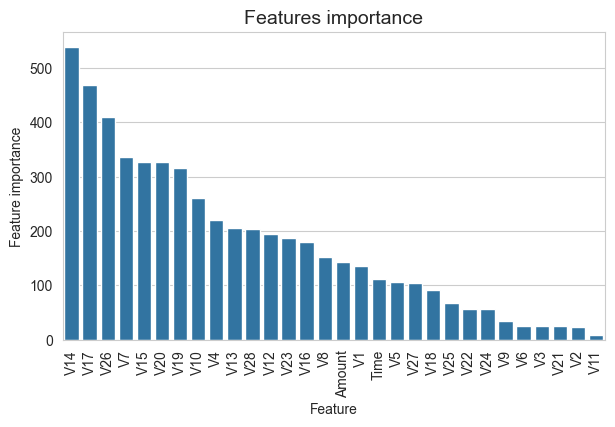

In [58]:
# feature importance

tmp = pd.DataFrame({'Feature': X_train.columns.to_numpy(), 'Feature importance': lgbm.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

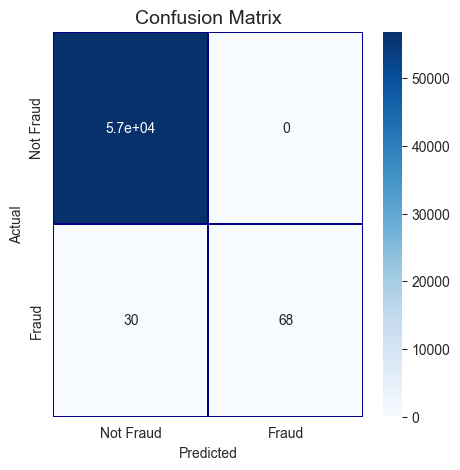

In [59]:
# confusion matrix

cm = pd.crosstab(Y_test.values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [60]:
# AUC-ROC

roc_auc_score(Y_test.values, preds)

0.846938775510204

The AUC-ROC score obtained with hyperparameter tuned LightGBM is 0.85.

As we observe, even with hyperparameter tuning, the model performed worse compared to our previous model without tuning. This shows that the highly imbalance nature of our dataset can skew results drastically, and stratified K-Fold without ovesampling techqniues is not enough to address the imbalance nature. It is better to oversample our minority cases on the training data prior to training the model.

The improvement to the model would be to create an algorithm to oversample the training data for each stratified K-Folds individually, before training the model and validating them with their respective validation sets. As this method is computationally intensive, I will leave it up to readers to attempt this and compare the results.